<a href="https://colab.research.google.com/github/MosaicGroupCMU/African-MRS-Tutorials/blob/main/QE_Silicon_Electron_Bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Electronic Band Structures in QuantumESPRESSO

In this Google Colab workbook, we will use QuantumESPRESSO to calculate and visualise the electronic band structure of silicon. As always, there will be an easy, medium, and hard version of this workbook.

Prerequisite: `Quantum_Espresso_Silicon.ipynb`

Contributors: [Seda Oturak](https://github.com/sedaoturak), [Ismaila Dabo](https://scholar.google.com/citations?user=rN299m0AAAAJ&hl=en), [Jessica Wen](https://github.com/JessicaWen-PhD), [Cierra Chandler](https://github.com/Cierra-Chandler), [Henry Eya](https://github.com/Henrynweya)


## Install libraries, environment, and QuantumESPRESSO

This part installs libraries for numerical calculations and plotting.

In [12]:
# load plotting libraries
import matplotlib.pyplot as plt

# load numerical libraries
import numpy as np

Quantum ESPRESSO is a plane wave code, which uses Fourier transforms to solve equations in plane wave space. This part installs libraries for fast Fourier transforms (FFTs).

In [13]:
# eliminate text output during installation
%%capture

# install mathematical libraries to peform fast Fourier transforms
# (the exclamation mark means that the command is run under Linux)
! apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc

The Atomic Simulation Environment (ASE) is a set of tools for running, visualizing, and analyzing simulations. This part installs ASE.

In [14]:
# eliminate text output during installation
%%capture

# install the Atomic simulation environment
# ! apt install ase
! pip install git+https://gitlab.com/ase/ase

Compiling Quantum ESPRESSO from scratch would take a long time. This part uploads pre-compiled executable files (`.x` extension) and additional files containing the pseudopotentials.

In [15]:
# eliminate text output during installation
%%capture

# navigate to main directory named '/content/'
%cd /content/

# download the pre-compiled files in compressed format (under Linux)
! wget 'https://docs.google.com/uc?export=download&id=1kw_CJMjP6ggDZXDNp5phAqCPpoe2WXCA' -O qe-lite.tgz

# unpack the compressed files (under Linux)
! tar -xvzf qe-lite.tgz

# clean up some files
! rm -rf sample_data qe-lite.tgz


Now we have installed all the libraries and executables, we can get started on our calculations.

---
## How to Calculate Electronic Band Structure with QuantumESPRESSO

QuantumESPRESSO provides us with all the tools that we need to calculate and plot the band structure. We follow the below steps:
1. Create an input file for `pw.x` and run a self-consistent field (SCF) calculation, like we did in `Quantum_Espresso_Silicon.ipynb`.
2. Run `pw.x` with calculation mode set to `bands`.
3. Use the `bands.x` utility to post-process the calculation data we got from step 2 into a more usable format.
4. Plot the band structure with `plotband.x`.
5. Analyse the generated band structure file to interpret the electronic properties of the material.

## How does the calculation work?

The `bands` calculation in the `pw.x` program is *non self-consistent* so we need to read out the ground state electron density, Hartree, exchange, and correlation potentials that we found in the SCF calculation.

The `pw.x` program finds the Kohn-Sham eigenfunction and eigenvalues without updating the Kohn-Sham Hamiltonian each time it iterates (hence why it is NOT a self-consistent calculation).

We need to specify the k-points at which the Eigenvalues will be calculated. A reminder that you can use the [See-K-path tool by Materials Cloud](https://www.materialscloud.org/work/tools/seekpath) to visualise the K-path. If you're advanced, you can use [XCrysDen](http://www.xcrysden.org/) to select a path in k-space.

We can specify `nbnd` so that it doesn't just do the default (which is when it calculates half the number of valence electrons, i.e. only the occupied ground state bands) - we are usually also interested in the unoccupied bands above the Fermi energy. The number of occupied bands can be found in the `scf` output as the number of Kohn-Sham states.

Explanation from the [QuantumESPRESSO tutorial by pranabdas on GitHub](https://pranabdas.github.io/espresso/hands-on/bands/).

---
## Prepare QuantumESPRESSO input file

First, we want to create a calculation folder and navigate into it. This is a good habit to get into because when we want to run lots of calculations, we want to keep them organised.

In [16]:
# create calculation folder and navigate into it
%mkdir -p /content/silicon
%cd /content/silicon/

/content/silicon


The calculation is for a unit cell of diamond silicon. Remember that the definition of the input parameters of the `pw.x` executable can be found at `www.quantum-espresso.org/Doc/INPUT_PW.html`.

We can use the optimal cutoff energies and k-points that we found for silicon in the convergence tests during the `Quantum_Espresso_Silicon.ipynb` workbook.

It might also be useful to use this paper, [(Herman, 1972)](https://ieeexplore.ieee.org/document/4055356), as a reference.

In [17]:
# create input and write it into the file si.scf.in
qe_input = """
&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/',
  verbosity='high',
  calculation='scf',
  restart_mode='from_scratch'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  nbnd=8,
  ! if you don't specify nbnd, it will default to half the number of electrons, which only gives you up to the Fermi energy
  occupations='smearing', smearing='mp', degauss=0.02,
  ! if you add smearing to the calculation, you need to specify the smearing parameters.
  ! smearing will mean that the calculations of the bands that electrons occupy will be less accurate, so it will produce the Fermi energy but not the lowest occupied/highest unoccupied states.
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   4 4 4 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0
"""

with open("si.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat si.scf.in


&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/',
  verbosity='high',
  calculation='scf',
  restart_mode='from_scratch'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  nbnd=8,
  ! if you don't specify nbnd, it will default to half the number of electrons, which only gives you up to the Fermi energy
  occupations='smearing', smearing='mp', degauss=0.02,
  ! if you add smearing to the calculation, you need to specify the smearing parameters.
  ! smearing will mean that the calculations of the bands that electrons occupy will be less accurate, so it will produce the Fermi energy but not the lowest occupied/highest unoccupied states.
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   4 4 4 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0


In the previous workbook, we visualised the silicon crystal. Here, we'll dive straight into the self-consistent field (SCF) calculation.

In [18]:
# run the pw.x executable using si.scf.in to create si.scf.out
! /content/qe-lite/bin/pw.x < si.scf.in > si.scf.out

# print the content of the output file (under Linux)
! cat si.scf.out


     Program PWSCF v.7.4 starts on  9Dec2024 at 20:32: 0 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     980 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input
     Message from routine read_cards :
     DEPRECATED: no units specified in CELL_PARAMETERS card

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angula

## Electronic band structure calculation input file

Now we can run the `bands` calculation. To begin, we need to create a band structure calculation input file.

In [19]:
# Create a new input file for the band structure calculation
band_input = """
&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/',
  calculation='bands'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  nbnd = 8,
  ! occupations='smearing', smearing='mp', degauss=0.02
/
&electrons
  conv_thr = 1e-8,
  mixing_beta = 0.6
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS crystal_b
5
  0.0000 0.5000 0.0000 20  !L
  0.0000 0.0000 0.0000 30  !G
  -0.500 0.0000 -0.500 10  !X
  -0.375 0.2500 -0.375 30  !U
  0.0000 0.0000 0.0000 20  !G
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0
"""

with open("si.bands.in", "w") as f:
    f.write(band_input)

# Print the content of the band structure input file (under Linux)
! cat si.bands.in


&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/',
  calculation='bands'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  nbnd = 8,
  ! occupations='smearing', smearing='mp', degauss=0.02
/
&electrons
  conv_thr = 1e-8,
  mixing_beta = 0.6
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS crystal_b
5
  0.0000 0.5000 0.0000 20  !L
  0.0000 0.0000 0.0000 30  !G
  -0.500 0.0000 -0.500 10  !X
  -0.375 0.2500 -0.375 30  !U
  0.0000 0.0000 0.0000 20  !G
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0


## Electronic band structure calculation

Run the `pw.x` executable with the input file from the previous step.

In [20]:
# Run the pw.x executable in the bands calculation mode using si.bands.in to create si.bands.out
! /content/qe-lite/bin/pw.x < si.bands.in > si.bands.out

# Print the content of the band structure output file (under Linux)
! cat si.bands.out


     Program PWSCF v.7.4 starts on  9Dec2024 at 20:32:11 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8908 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input
     Message from routine read_cards :
     DEPRECATED: no units specified in CELL_PARAMETERS card

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angul

## Post-processing and visualisation

Now that we have done the `bands` calculation, we can use the `bands.x` executable to do our post-processing of the data.

In [21]:
# Input file for the `bands.x` executable
band_pp = """
&bands
  prefix='silicon',
  outdir='/content/silicon/',
  filband='si_bands.dat'
/
"""

with open("pp.si.bands.in", "w") as f:
    f.write(band_pp)

# Print the content of the band structure input file (under Linux)
! cat pp.si.bands.in


&bands
  prefix='silicon',
  outdir='/content/silicon/',
  filband='si_bands.dat'
/


Run `bands.x` with our post-processing input file.

In [22]:
# Run the bands.x executable using pp.si.bands.in to create pp.si.bands.out
! /content/qe-lite/bin/bands.x < pp.si.bands.in > pp.si.bands.out

# Print the content of the band structure output file (under Linux)
! cat pp.si.bands.out


     Program BANDS v.7.4 starts on  9Dec2024 at 20:32:23 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8891 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     /content/silicon/silicon.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBE
                           (   1   4   3   4   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G

Visualise the calculated band structure with `plotband.x`, either by running it interactively through typing `plotband.x` in your terminal or by providing an input file.

We will first use `plotband.x`. Here's a hint for what you should put in the terminal prompts.


```
     Input file > si_bands.dat
Reading    8 bands at     91 k-points
Range:   -6.4340   12.6300eV  Emin, Emax, [firstk, lastk] > -6, 16
high-symmetry point:  0.5000-0.5000 0.5000   x coordinate   0.0000
high-symmetry point:  0.0000 0.0000 0.0000   x coordinate   0.8660
high-symmetry point:  0.0000-1.0000 0.0000   x coordinate   1.8660
high-symmetry point:  0.2500-1.0000 0.2500   x coordinate   2.2196
high-symmetry point:  0.0000 0.0000 0.0000   x coordinate   3.2802
output file (gnuplot/xmgr) > si_bands.gnuplot
bands in gnuplot/xmgr format written to file si_bands.gnuplot                                                                                                                                                                                                                                                
output file (ps) > si_bands.ps
Efermi > 6.6416
deltaE, reference E (for tics) 4, 0
bands in PostScript format written to file si_bands.ps   
```


In [23]:
# Use plotband.x on the si_bands.dat file to create the band diagrom in the output file si_bands.ps.
! /content/qe-lite/bin/plotband.x

     Input file > ^C


We will now try an alternative way with matplotlib and numpy.

Most of the processing is converting the si_bands.dat.gnu data into x-y data that we can plot with any software. The data in si_bands.dat.gnu is formatted relatively predictably, so we can go band-by-band and extract the data into energy vs k-point data.

This process stores the lowest band energy first, then the next lowest, and so on until all the bands in the band structure have been extracted.

Explanation from [Levi Lentz's Band Diagram Tutorial for Quantum Espresso](https://blog.levilentz.com/band-diagram-tutorial-for-quantum-espresso/).

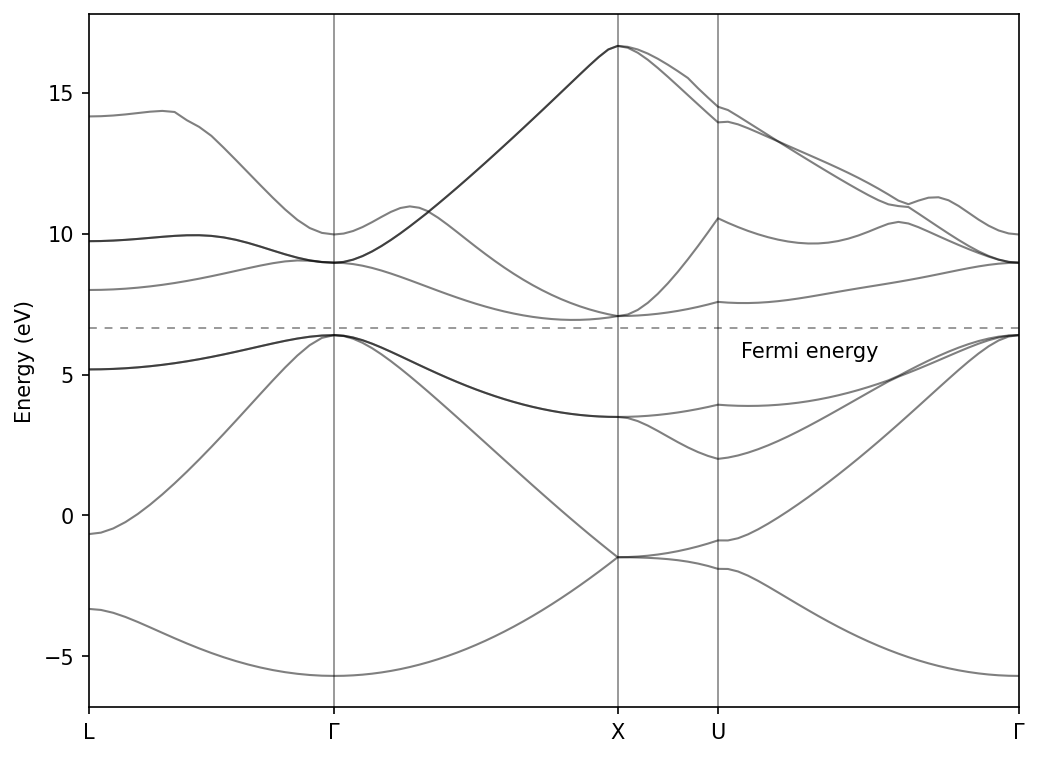

In [24]:
# We can use your favourite plotting program to make the plots.
# Here, we'll once again use Python's matplotlib to plot the band structure.
plt.rcParams["figure.dpi"]=150
plt.rcParams["figure.facecolor"]="white"
plt.rcParams["figure.figsize"]=(8, 6)

# load data
data = np.loadtxt('/content/silicon/si_bands.dat.gnu')

k = np.unique(data[:, 0])
bands = np.reshape(data[:, 1], (-1, len(k)))

for band in range(len(bands)):
    plt.plot(k, bands[band, :], linewidth=1, alpha=0.5, color='k')
plt.xlim(min(k), max(k))

# Fermi energy
plt.axhline(6.6416, linestyle=(0, (5, 5)), linewidth=0.75, color='k', alpha=0.5)
# High symmetry k-points (check bands_pp.out)
plt.axvline(0.8660, linewidth=0.75, color='k', alpha=0.5)
plt.axvline(1.8660, linewidth=0.75, color='k', alpha=0.5)
plt.axvline(2.2196, linewidth=0.75, color='k', alpha=0.5)
# text labels
plt.xticks(ticks= [0, 0.8660, 1.8660, 2.2196, 3.2802], \
           labels=['L', '$\Gamma$', 'X', 'U', '$\Gamma$'])
plt.ylabel("Energy (eV)")
plt.text(2.3, 5.6, 'Fermi energy')
plt.show()

The high-symmetry points like those labelled on our diagram (Γ, X, U, L) can be found in the post-processing output file (`pp.si.bands.out`).

We can use the plot to determine the band gap value, but we can be more accurate by finding the difference between the highest occupied level and the lowest unoccupied level from the scf calculation output.

In [25]:
# Band gap calculation
! grep -e "highest occupied, lowest unoccupied level (ev):" si.scf.out

In [26]:
bandgap = 7.2619 - 6.1022;
print("Band gap = ", bandgap, "eV")

Band gap =  1.1597 eV


Now we can find the Fermi energy.

In [27]:
# Fermi energy
fermi_energy = 7.2619 - bandgap/2;
print("Fermi energy = ", fermi_energy, "eV")

Fermi energy =  6.68205 eV


Compare this to the experimental value of the silicon band gap of 1.170 eV [(Bludau, Onton and Heinke, 1974)](https://pubs.aip.org/aip/jap/article-abstract/45/4/1846/507373/Temperature-dependence-of-the-band-gap-of-silicon).

## Drawbacks of this method to calculate band gaps

In these calculations, LDA or GGA are commonly used as the exchange-correction functionals. However, these severely underestimate band gaps (i.e. experimental band gap values are generally much higher). According to [pranabdas](https://pranabdas.github.io/espresso/hands-on/bands/), this difference can be attributed to:

1. Approximations used in the exchange correction functional, and
2. A derivative discontinuity term, originating from the density functional being discontinuous with the total number of electrons in the system.

The second point is the larger contributor to the error. Many different techniques have been developed that partially address this problem, such as the GW approximation, which you can specify in the input file.

"Strategies to improve band gap prediction at moderate to low computational cost now been developed by several groups, including [Chan and Ceder](https://doi.org/10.1103/PhysRevLett.105.196403) (delta-sol), [Heyd et al.](https://doi.org/10.1063/1.2085170) (hybrid functionals), and [Setyawan et al.](https://doi.org/10.1021/co200012w) (empirical fits)." -- see the [QuantumESPRESSO tutorial by pranabdas on GitHub](https://pranabdas.github.io/espresso/hands-on/bands/).